# Mô hình ARIMA dự báo giá cổ phiếu HVN 

Thực hiện theo quy trình Box-Jenkins cho chuỗi thời gian giá đóng cửa (Close).
Dữ liệu: result.xlsx (từ 2021-12-13 đến 2025-02-28)

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

## Tiền xử lý dữ liệu
- Chuyển Date thành datetime và đặt làm index
- Lấy chuỗi Close để dự báo

In [2]:
# Đọc dữ liệu
df = pd.read_excel('result.xlsx')  # thay bằng đường dẫn thực tế nếu cần
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()  # đảm bảo thứ tự thời gian

# Lấy chuỗi giá đóng cửa
series = df['Close'].dropna()
print("Kích thước chuỗi dữ liệu:", len(series))
print(series.head())

Kích thước chuỗi dữ liệu: 495
Date
2021-12-13    1962.3
2021-12-14    1966.2
2021-12-15    1915.0
2021-12-16    1840.1
2021-12-17    1848.0
Name: Close, dtype: float64


## Kiểm tra tính dừng bằng ADF Test
Nếu p-value > 0.05 → chuỗi không dừng → cần sai phân

In [3]:
# ADF Test trên chuỗi gốc
adf_result = adfuller(series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

# Nếu không dừng, lấy sai phân bậc 1
if adf_result[1] > 0.05:
    series_diff = series.diff().dropna()
    print("\nSau khi lấy sai phân bậc 1:")
    adf_diff = adfuller(series_diff)
    print('ADF Statistic (diff):', adf_diff[0])
    print('p-value (diff):', adf_diff[1])
else:
    series_diff = series

ADF Statistic: -1.4267053735946083
p-value: 0.5694083974828081
Critical Values: {'1%': np.float64(-3.4437660979098843), '5%': np.float64(-2.8674565460819896), '10%': np.float64(-2.569921291128696)}

Sau khi lấy sai phân bậc 1:
ADF Statistic (diff): -9.035167610559077
p-value (diff): 5.313402670326539e-15


## ACF và PACF để xác định tham số p, q (d=1)

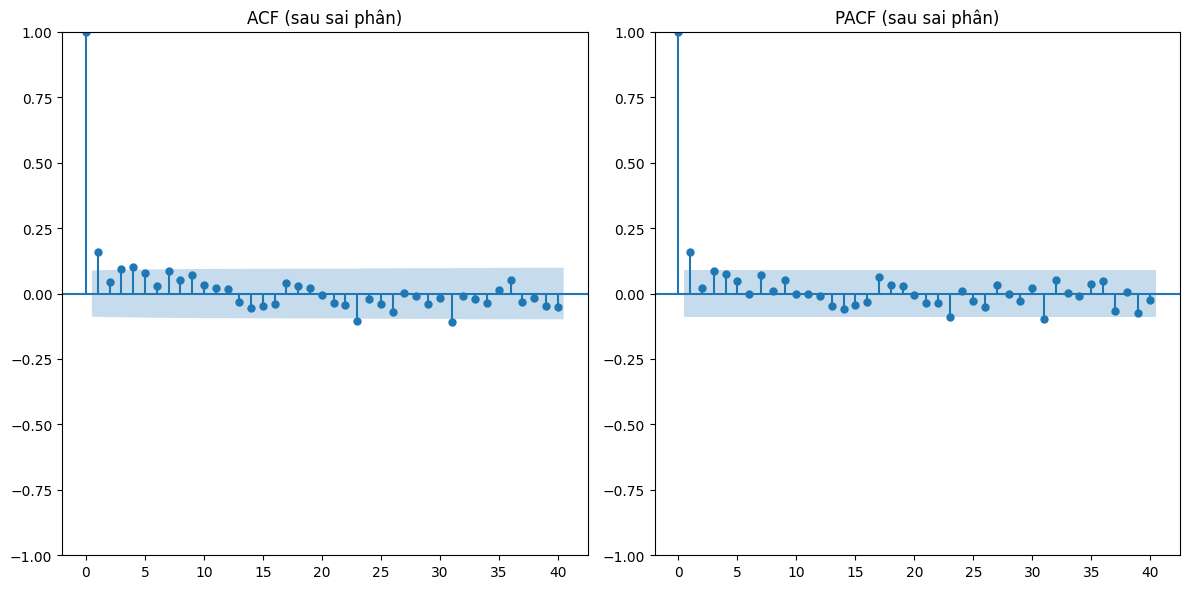

In [4]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(series_diff, lags=40, ax=plt.gca())
plt.title('ACF (sau sai phân)')

plt.subplot(122)
plot_pacf(series_diff, lags=40, method='ywm', ax=plt.gca())
plt.title('PACF (sau sai phân)')

plt.tight_layout()
plt.show()

## Grid search thủ công tìm (p,d,q) có AIC thấp nhất
Thử p=0..2, d=1, q=0..2

In [5]:
best_aic = float("inf")
best_order = None
best_model = None

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(series, order=(p, 1, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, 1, q)
                best_model = model_fit
            print(f'ARIMA({p},1,{q}) - AIC: {aic:.2f}')
        except:
            continue

print("\nMô hình tốt nhất:", best_order, "với AIC =", best_aic)


ARIMA(0,1,0) - AIC: 5329.36
ARIMA(0,1,1) - AIC: 5318.98
ARIMA(0,1,2) - AIC: 5320.76
ARIMA(1,1,0) - AIC: 5318.47
ARIMA(1,1,1) - AIC: 5315.52
ARIMA(1,1,2) - AIC: 5316.09
ARIMA(2,1,0) - AIC: 5320.28
ARIMA(2,1,1) - AIC: 5316.35
ARIMA(2,1,2) - AIC: 5316.71

Mô hình tốt nhất: (1, 1, 1) với AIC = 5315.521115259538


## Fit mô hình ARIMA tốt nhất và kiểm tra summary

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  495
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2654.761
Date:                Fri, 16 Jan 2026   AIC                           5315.521
Time:                        17:55:12   BIC                           5328.129
Sample:                             0   HQIC                          5320.471
                                - 495                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8380      0.061     13.765      0.000       0.719       0.957
ma.L1         -0.7337      0.079     -9.269      0.000      -0.889      -0.579
sigma2      2724.1772     81.283     33.515      0.0

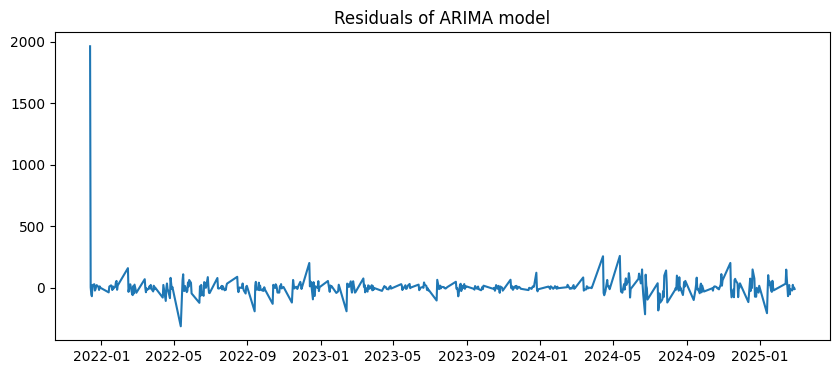

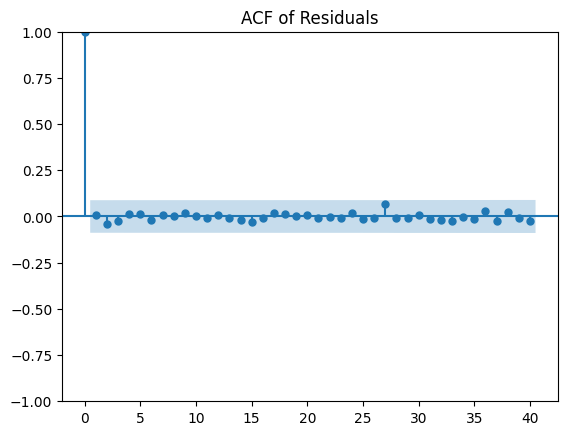

In [6]:
# Fit lại mô hình tốt nhất
final_model = ARIMA(series, order=best_order)
final_fit = final_model.fit()

print(final_fit.summary())

# Kiểm tra phần dư
residuals = final_fit.resid
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals of ARIMA model')
plt.show()

# ACF phần dư (nên gần 0)
plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()

## Chia train/test (80/20) và dự báo
Đánh giá RMSE, MAE, MAPE

In [7]:
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Fit trên train
train_model = ARIMA(train, order=best_order)
train_fit = train_model.fit()

# Dự báo số bước bằng độ dài test
forecast_steps = len(test)
forecast = train_fit.forecast(steps=forecast_steps)

# Đánh giá
rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 768.62
MAE: 723.77
MAPE: nan%


## Đồ thị so sánh thực tế và dự báo

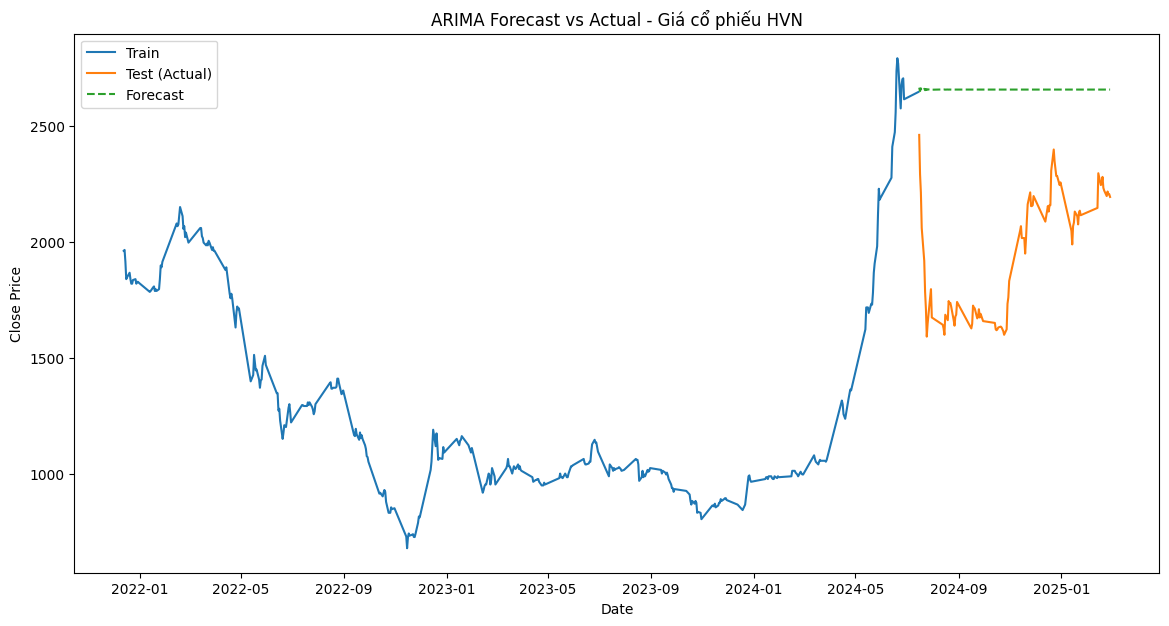

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test (Actual)')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast vs Actual - Giá cổ phiếu HVN')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## 4.1.1. Các chỉ số thống kê mô tả
Tính toán thống kê cơ bản cho giá Close, Return_pct, Volume và các biến vĩ mô

In [9]:
# Thống kê mô tả toàn bộ dataframe
print("Thống kê mô tả các biến chính:")
print(df[['Close', 'Return_pct', 'Volume', 'Brent', 'USDVND', 'CPI']].describe())

# Thống kê chi tiết hơn cho Close
print("\nThống kê chi tiết giá Close:")
print("Trung bình:", df['Close'].mean())
print("Độ lệch chuẩn:", df['Close'].std())
print("Min:", df['Close'].min())
print("Max:", df['Close'].max())
print("Số quan sát:", len(df))

# Lưu bảng thống kê ra Excel để chèn vào Word
df_stats = df[['Close', 'Return_pct', 'Volume', 'Brent', 'USDVND', 'CPI']].describe()
df_stats.to_excel('HVN_descriptive_stats.xlsx')
print("\nĐã lưu bảng thống kê vào HVN_descriptive_stats.xlsx")

Thống kê mô tả các biến chính:
             Close  Return_pct        Volume       Brent        USDVND  \
count   495.000000  495.000000  4.950000e+02  495.000000    495.000000   
mean   1406.336768    0.000917  2.656466e+06   86.395939  24140.135354   
std     493.518515    2.546193  1.921655e+06   11.843306    885.092037   
min     678.500000   -6.994222  2.647000e+05   71.040000  22625.000000   
25%     996.900000   -1.206940  1.486000e+06   78.135000  23445.000000   
50%    1221.500000    0.000000  2.150500e+06   83.470000  24155.000000   
75%    1792.850000    1.209063  3.214400e+06   91.425000  24842.000000   
max    2793.700000    6.971260  1.437770e+07  122.840000  25535.000000   

              CPI  
count  495.000000  
mean   110.316483  
std      3.527266  
min    105.949940  
25%    107.365830  
50%    109.512020  
75%    112.447378  
max    121.417810  

Thống kê chi tiết giá Close:
Trung bình: 1406.3367676767675
Độ lệch chuẩn: 493.5185150303786
Min: 678.5
Max: 2793.7
Số qu

## 4.1.2. Diễn biến giá HVN
Vẽ đồ thị chuỗi thời gian giá Close và Return_pct để quan sát xu hướng

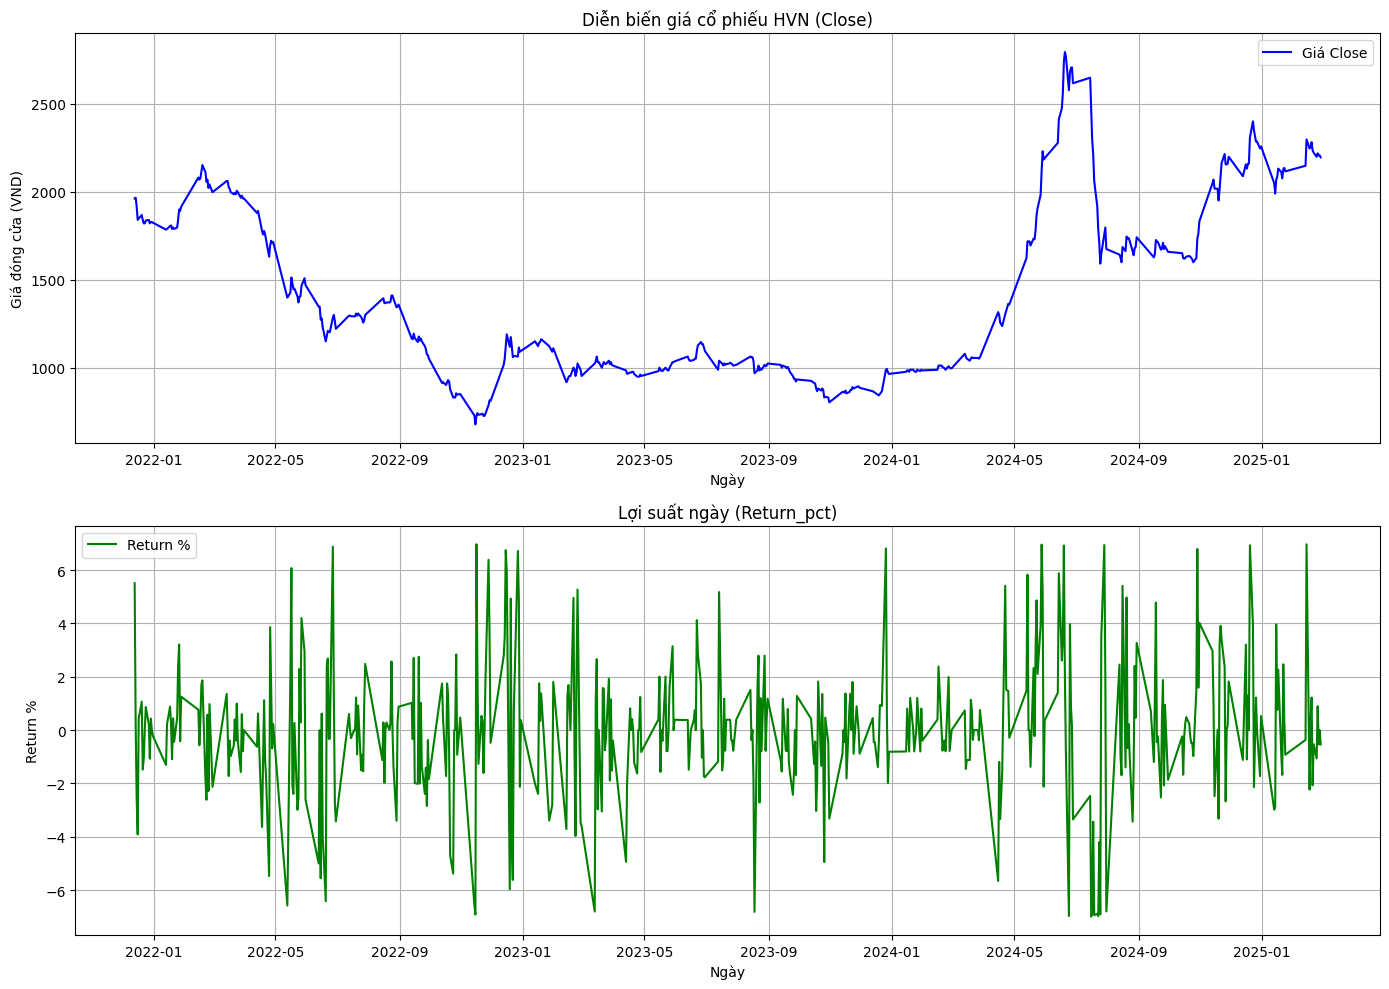

Đã lưu đồ thị diễn biến giá vào HVN_price_trend.png


In [10]:
plt.figure(figsize=(14, 10))

# Đồ thị giá Close
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], color='blue', label='Giá Close')
plt.title('Diễn biến giá cổ phiếu HVN (Close)')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa (VND)')
plt.legend()
plt.grid(True)

# Đồ thị Return_pct
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Return_pct'], color='green', label='Return %')
plt.title('Lợi suất ngày (Return_pct)')
plt.xlabel('Ngày')
plt.ylabel('Return %')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('HVN_price_trend.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu đồ thị diễn biến giá vào HVN_price_trend.png")

## 4.1.3. Ma trận tương quan giữa HVN và các biến vĩ mô
Tính và hiển thị ma trận tương quan để phân tích mối quan hệ

Ma trận tương quan:
           Close     Brent    USDVND       CPI
Close   1.000000 -0.045301  0.251848 -0.001539
Brent  -0.045301  1.000000 -0.484253  0.792534
USDVND  0.251848 -0.484253  1.000000 -0.178154
CPI    -0.001539  0.792534 -0.178154  1.000000


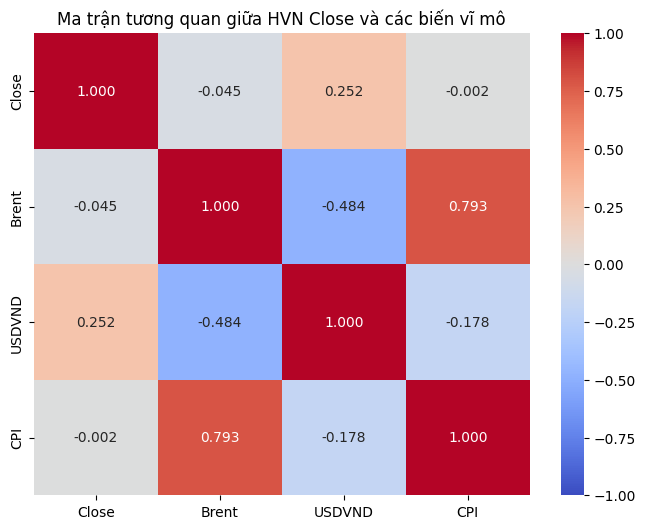

Đã lưu heatmap tương quan vào HVN_correlation_heatmap.png


In [12]:
# Ma trận tương quan
corr_matrix = df[['Close', 'Brent', 'USDVND', 'CPI']].corr()

print("Ma trận tương quan:")
print(corr_matrix)

# Vẽ heatmap để trực quan hóa
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.3f')
plt.title('Ma trận tương quan giữa HVN Close và các biến vĩ mô')
plt.savefig('HVN_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("Đã lưu heatmap tương quan vào HVN_correlation_heatmap.png")